In [2]:
import numpy as np
import matplotlib.pyplot as plt

**Trening av nettverkene**

Vi har i filene layers.py og neural_network.py definert nødvendige klasser med tilhørende medlemsfunksjoner til å trene en transformermodell til å predikere neste tall i en sekvens. Vi bruker dette til å trene en modell til å addere to to-sifrede heltall og en modell til å sortere en rekke heltall i stigende rekkefølge. Kode for dette ligger i training_algorithm.py. For å trene disse modellene oppdaterer vi en rekke parametere slik at lossfunkjsonen vår skal gå mot null ved steg av Adam. For å sjekke om lossfunksjonen faktisk minimeres plotter vi gjennomsnittet av lossfunksjonen over en batch som en funksjon av antall itterasjoner. 

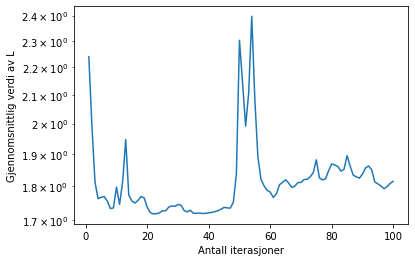

In [3]:
from training_algorithm import TrainingAlgorithm

nn_adding, mean_losses_adding = TrainingAlgorithm(problem=0, L=2, n_iters=100, step='adam')
#nn_sorting, mean_losses_sorting = TrainingAlgorithm(1)

n = np.arange(1, len(mean_losses_adding)+1)

plt.xlabel('Antall iterasjoner')
plt.ylabel('Gjennomsnittlig verdi av L')
plt.yscale("log")
plt.plot(n, mean_losses_adding)


**Testing og analyse av modellen**

Når koden har trent et nevralt nettverk vil den kunne summere to to-sifrede heltall eller sortere en rekke i stigende rekkefølge. Vi sjekker hvor godt de fungerer i koden under, der vi finner prosentandelen av input som gir riktige resultater. Modellen predikerer bare det neste tallet i sekvensen, så er vi ute etter et resultat med lengde n må vi kjøre n inputs inn i modellen, der vi hver gang legger til resultatet på neste input. Siden det er en eller flere feil i treningen kan vi ikke utføre testen slik vi ønsker, men all nødvendig kode er implementert.

In [ ]:
from training_algorithm import prosentSortetRight, prosentAddedRight

prosent_adding = prosentAddedRight(nn_adding, 500)
print(f'Prosentandel av input som ble riktig med nåværende modell for addisjon er: {prosent_adding}')

prosent_sorting = prosentSortetRight(nn_adding, 5, 500)
print(f'Prosentandel av input som ble riktig med nåværende modell for addisjon er: {prosent_sorting}')

## Debugging ved feil minimering av Loss-funksjonen

Under trening av algoritmen opplevede vi lenge to større feil ved minimering av Loss-funksjonen. Gjennom debuggingen fant vi deler av problemet da vi i bacwards for CrossEntropy hadde implementert feil formel for utregningen av dLdY. Dette løste imidlertidig ikke alt, og Loss-funksjonen synker ikke slik vi ønsker. Vi har derfor likevel valgt å vise til debugging-prosessen vi gjennomgikk for følgende feil hvor feil 2 er delvis løst:\

**Feil 1:** Både step_Adam og step_gd gir en økning i verdien til Loss-funksjonen. Step_Adam flukturerer og konvergerer ikke mot en lav verdi.\
**Feil 2:** Bruk av step_Adam gir "RuntimeWarning: divide by zero encountered in log q = -np.log(p)" for attention forward og loss funksjonen konvergerer mot inf.

Under debuggingen  har vi utforsket følgende hypoteser: 
1) Matriseelementer i p i attention forward er lik null, og np.log(p) gir feilmenldinger da logaritmen til 0 ikke eksisterer. Det er flere grunner til at p kan bli lik null, blant dem:
    - self.Y = onehot(y,m) blir null: dersom onehot ikke fungerer som den skal og og ikke leverer verdier lik 1 vil den kunne gi en null-matrise for self.Y = onehot(y,m). Vi sjekket derfor max-verdien i hver kolonne til onehot-matrisen og fikk at samtlige hadde en verdi 1. Onehot fungerer derfor tilsynelatende som den skal. 
    - self.Y_hat = Z[:,:,-r:] blir null: dersom Z = nn.forward(X) ikke fungerer slik den skal vil den kunne gi ut en Z som blir enten null eller veldig liten. Til å teste dette printet vi retur-verdien til hvert lag i forward. Vi oppdager at flere verdier i softmax divergerer mot null men tester samtidig kollonnesummene og ser at disse er lik 1 (eller tilnærmet lik +-10**-8). Siden Softmax er en sannsynlighetsfordeling kan det stemme at flere av elementene har sannsynligheter som er nærmest lik null, og siden kollonnesummene stemmer finner vi ingen åpenbare kilder til feil for Z.
2) Dimensjonsfeil 
    - dersom slizingen av Z ikke er gjort riktig og gir feil self.Y_hat = Z kan dette være en kilde til feil. Her sjekket vi derfor at både Y_hat og Y har like dimensjoner (bxmxn)
    - feil bruk av einsum vil kunne gi feil dimensjoner som kan gå utover f.eks np.sum()-funksjonene som behandler sannsynlighetsfordelingene i forward pass eller på andre måter gjøre at informasjon går tapt i nettverket. Vi printet "shapen" til matrisene og forsikret oss om at de gir ut riktige dimensjoner. 

3) Feil i training_algorithm
    - dersom algoritmen ikke får med seg nok informasjon fra nettverket til å beregne gradientene kan minimeringen av L bli ustabil. Vi testet derfor for flere attention lag, men fant at ved økning av lag gikk loss-funksjonen fortere mot inf eller en annen høyere verdi, og at dette derfor heller ikke er en sannsynlig kilde til problemet.
    - step_size har sammenheng med konvergenshastighen, og en endring i step_size vil påvirke hvor raskt eller sakte algoritmen konvergerer mot et optimalt punkt. I vårt tilfelle hvor funkjonen konvergerer vekk fra det optimale erfarte vi derfor at en mindre step_size ga funksjonen flere verdier før inf ble nådd. Selv om vi med en mindre step_size kunne se at Loss-funksjonen for enkelte områder ble mindre for step_adam, så vi likevel ikke noe tegn til at Loss-fungeren minket til en lav verdi. Vi vurderer derfor ikke læringsraten som en sannsynlig feilkilde. 
4) Feil i implimentering av algoritmer:
    - Ut i fra feilen vår og konklusjoner fra punkt 1) kunne det virke som det det ligger en feil i implimenteringen av algoritmer. Vi fant, etter mye stirring, en feil i CrossEntropy.Backward, da vi hadde "dLdY = (1/self.n)*(np.multiply(padded_Y,self.Z+eps))" mens det skulle være "dLdY = -(1/self.n)*(padded_Y/(self.Z+eps))". Dette rettet dessvere ikke opp i alt, loss-funksjonen konvergerer ikke mot inf lenger, men flukturer rundt en verdi når vi kjører koden med step_adam og L=1. Kjører vi imidlertid den oppdatterte algoritmen på flere lag, trigges igjen inf-problemet for Adam. (plot 3)

Situasjonen vi da står igjen med er derfor følgende:
* For ett lag: bruk av adam gir ikke en avtakende Loss-funksjon. Gradient descent avtar, men bruker lang tid på å oppnå lavere verdier (plott 1-2)
* For to lag: inf-problematikk med Adam. Samme problem for gradient descent som for ett lag. (plott 3-4)

Siden vi får feil resultat ved bruk av begge optimeringsfunksjonene og feilen blir større ved bruk av flere lag mistenker vi at det ligger en feil i implementeringen av lagene for treningen av nettverket. Vi merker oss også at step_adam er betydelig dårligere enn step_gd for ett enkelt lag, og ser på det som sannsynlig at det ligger en feil også her (selv om dette er vanskelig å vurdere når dette også mulig skyldes feilen i nettverkslagene). Vi vurderer imidlertid at det er sannsynlig at vi har to uavhengige feil i programmet vårt, hvor den ène ligger i implementasjonen av lagene, og den andre er knyttet til step_adam. Vi har per tid ikke funnet kilden til feilen. 

Nedenfor finnes plott som viser oppførselen til Loss-funksjonen i de forskjellige situasjonene:


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from training_algorithm import TrainingAlgorithm

nn_adding_0, mean_losses_adding_0 = TrainingAlgorithm(problem=0, L=1, n_iters=100, step='adam') #addisjonsproblem
nn_adding_1, mean_losses_adding_1 = TrainingAlgorithm(problem=1, L=1, n_iters=100, step='adam') #sorteringsproblem


n = np.arange(1, len(mean_losses_adding_1)+1)
plt.yscale("log")
plt.plot(n, mean_losses_adding_0, label='Addisjonsproblem')
plt.plot(n, mean_losses_adding_1, label='Sorteringsproblem')
plt.legend()
plt.title("Plot 1: Adam for ett lineært lag")
plt.show()

nn_adding_0, mean_losses_adding_0 = TrainingAlgorithm(problem=0, L=1, n_iters=100, step='gd') #addisjonsproblem
nn_adding_1, mean_losses_adding_1 = TrainingAlgorithm(problem=1, L=1, n_iters=100, step='gd') #sorteringsproblem

n = np.arange(1, len(mean_losses_adding_1)+1)
plt.yscale("log")
plt.plot(n, mean_losses_adding_0, label='Addisjonsproblem')
plt.plot(n, mean_losses_adding_1, label='Sorteringsproblem')
plt.legend()
plt.title("Plot2: Gradient descent for ett lineært lag")
plt.show()

#tar ofte ikke mer enn n_iters = 40 før inf-problemet trigges
nn_adding_0, mean_losses_adding_0 = TrainingAlgorithm(problem=0, L=2, n_iters=40, step='adam') #addisjonsproblem
nn_adding_1, mean_losses_adding_1 = TrainingAlgorithm(problem=1, L=2, n_iters=40, step='adam') #sorteringsproblem


n = np.arange(1, len(mean_losses_adding_1)+1)
plt.yscale("log")
plt.plot(n, mean_losses_adding_0, label='Addisjonsproblem')
plt.plot(n, mean_losses_adding_1, label='Sorteringsproblem')
plt.legend()
plt.title("Plot 3: Adam for to lineære lag")
plt.show()

nn_adding_0, mean_losses_adding_0 = TrainingAlgorithm(problem=0, L=2, n_iters=100, step='gd') #addisjonsproblem
nn_adding_1, mean_losses_adding_1 = TrainingAlgorithm(problem=1, L=2, n_iters=100, step='gd') #sorteringsproblem

n = np.arange(1, len(mean_losses_adding_1)+1)
plt.yscale("log")
plt.plot(n, mean_losses_adding_0, label='Addisjonsproblem')
plt.plot(n, mean_losses_adding_1, label='Sorteringsproblem')
plt.legend()
plt.title("Plot 4: Gradient descent for to lineære lag")
plt.show()